Imports

In [1]:
import numpy as np
import pandas as pd
import torch, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, math, random
from statistics import mean

In [2]:
# Global Settings
random.seed(10)

# Scenario 1 (Fixed Sender With Non-Value Role Selection)

Class Agent

In [3]:
class Agent():
    def __init__(self):
        # Agent roles -> 0:A, 1:B
        self.role = None
        self.p_adding_signals = 0.1
        self.payoff = None
        self.P_A = 0.5
        self.P_B = 0.5
        self.signals = []
        self.sender = False
        self.receiver = False
        self.chosen_sig = None
        self.confidence_threshhold = 0.1
        self.decay_signals = 0.99

    def pick_best_word(self, word_list):
        best_word = [word for word in word_list if word[-1] == max([sublist[-1] for sublist in word_list])]
        return best_word[0]
    

    def check_signals(self):
        chosen_signal = None
        words_known = []
        for word in self.signals:
            if word[1] == self.role:
                words_known.append(word)
        if len(words_known) != 0:
            chosen_signal = self.pick_best_word(words_known)
        return chosen_signal
    
    def create_signal(self, rand_nr, counter):
        chosen_signal = None
        if rand_nr < self.p_adding_signals:
            sig1 = "w" + str(counter)
            counter += 1
            generated_signal = [sig1, self.role, 0.5]
            self.signals.append(generated_signal)
            chosen_signal = generated_signal
        return chosen_signal, counter

    def send_signal(self, counter):
        chosen_signal = None
        rand_nr = random.uniform(0,1)
        if self.sender:
            if len(self.signals) != 0:
                chosen_signal = self.check_signals()
                if chosen_signal is not None:
                    return chosen_signal, counter

                rand_signal = self.create_signal(rand_nr, counter)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal , counter
            else:
                rand_signal = self.create_signal(rand_nr, counter)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal, counter
        return chosen_signal, counter

    def select_role(self):
        if self.receiver:
            if self.P_A > self.P_B:
                self.role = 0
            elif self.P_B > self.P_A:
                self.role = 1
            else:
                self.role = random.choice([0,1])
        else:
            self.role = random.choice([0,1])
        return self.role

    def remove_unused_signals(self):
        for elm1 in self.signals:
            if elm1[-1] < self.confidence_threshhold:
                self.signals.remove(elm1)
    
    def decay_confidences(self):
        for elm1 in self.signals:
            elm1[-1] = elm1[-1] * self.decay_signals
    
    def update_probabilities(self, chosen_signal):
        if self.receiver:
            if chosen_signal is not None:
                if len(self.signals) != 0:
                    for sigs in self.signals:
                        if chosen_signal[0] == sigs[0]:
                            self.chosen_sig = sigs
                            if sigs[1] == 0:
                                self.P_A = 1
                                self.P_B = 0
                            elif sigs[1] == 1:
                                self.P_A = 0
                                self.P_B = 1
                            return True
                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    self.signals.append([chosen_signal[0], rand_ind, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, 0.5]
                else:
                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    self.signals.append([chosen_signal[0], rand_ind, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, 0.5]
                return True
        return True

The Game

In [4]:
results = []
agreements = []
payoffsTrendRounds = []
nr_experiments =30
for gameRound in range(nr_experiments):
    # Settings:
    nr_agents = 2
    time = 10000
    agents = []
    learning_rate = 0.5
    counter = 0
    pairs1 = np.zeros(time)
    pairs2 = np.zeros(time)

    # Create agents:
    for i in range(nr_agents):
        agents.append(Agent())
        agents[i].payoff = np.zeros(time)

    # Determine Pairs of Sender and Recievers only once throughout the game
    rand_index_sender = random.choice(range(len(agents)))
    sender_agent = agents[rand_index_sender]
    receiver_agent = agents[1-rand_index_sender]
    sender_agent.sender = True
    sender_agent.receiver = False
    receiver_agent.sender = False
    receiver_agent.receiver = True

    # The main framework that controls the game
    for t in range(1, time):
        selections_list = []
        # communication phase
        sender_agent.select_role()
        selections_list.append(sender_agent.role)
        sent = sender_agent.send_signal(counter)
        chosen_signal = sent[0]
        counter = sent[1]
        receiver_agent.update_probabilities(chosen_signal)
        receiver_agent.select_role()
        selections_list.append(receiver_agent.role) 
        payoffs_list = np.zeros(len(agents))
    
        # Check signals after each 10 iteration
        if t%2 == 0:
            for agent in agents:
                agent.remove_unused_signals()
    
        # Calculate payoffs
        # To change the Games, simply uncomment the corresponding lines and comment the othe rules
    #################################################################################################
        # Games 1: All agents must have the same roles
        for i in range(len(agents)):
            if all(roles == selections_list[0] for roles in selections_list):
                payoffs_list[i] += 5
            else:            
                payoffs_list[i] += 0
    #################################################################################################
        # # Games 2: All agents must not have the same roles
        # for i in range(len(agents)):
        #     if not all(roles == selections_list[0] for roles in selections_list):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # # Games 3: Sender must have role A (0), Receivers must have role B (1)
        # for i in range(len(agents)):
        #     if (sender_agent.role == 0) and (receiver_agent.role == 1):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # distribute rewards
        for i in range(len(agents)):
            agents[i].payoff[t] = payoffs_list[i]
            agents[i].decay_confidences()
        # Check if communication was successful
        if chosen_signal is not None:
            for elm1 in sender_agent.signals:
                if elm1 == chosen_signal:
                    elm1[-1] += learning_rate * (sender_agent.payoff[t] - elm1[-1])
                    if elm1[-1] < 0:
                        elm1[-1] = 0
                    elif elm1[-1] > 1:
                        elm1[-1] = 1
            for elm2 in receiver_agent.signals:
                if elm2 == receiver_agent.chosen_sig:
                    elm2[-1] += learning_rate * (receiver_agent.payoff[t] - elm2[-1])
                    if elm2[-1] < 0:
                        elm2[-1] = 0
                    elif elm2[-1] > 1:
                        elm2[-1] = 1

    # Checking the semantic similarity between all agents
    # Note: to match the corresponding Games, uncomment the corresponding section and comment the others
    #################################################################################################
    # Matching with Games 1:
    successful = []
    signal_list = [receiver_agent.signals, sender_agent.signals]
    for x,y in zip(*signal_list):
        if (x[-1] > 0.5) and (y[-1] > 0.5):
            successful.append((x[0]==y[0]) and (x[1]==y[1]))
    #################################################################################################
    # # Matching with Games 2, 3:
    # successful = []
    # signal_list = [receiver_agent.signals, sender_agent.signals]
    # for x,y in zip(*signal_list):
    #     if (x[-1] > 0.5) and (y[-1] > 0.5):
    #         successful.append((x[0]==y[0]) and not(x[1]==y[1]))
    #################################################################################################

    f5 = open("Sccenari1_results.txt", "a")
    print("\n\nRound {}".format(gameRound), sep=',', file=f5)
    print("Game {}".format(t), sep=',', file=f5)
    for i in range(len(agents)):
        print("agent[{}] signals is:{}".format(i, agents[i].signals), sep=',', file=f5)
    f5.close()

    result = []
    for i in range(len(agents)):
        result.append(agents[i].payoff)
    results.append(result)
    if all(x == True for x in successful):
        agreed = True
    else:
        agreed = False
    agreements.append(agreed)

In [5]:
results_df = pd.DataFrame(results)
sum_df = 0
for i in range(len(results_df.columns)):
    sum_df += results_df[i]
avg_df = (sum_df / len(results_df.columns)).mean()
agreement_percent = (agreements.count(True) / len(agreements) ) * 100
print("the percentage of the games that had agreement is:{}%".format(agreement_percent))

the percentage of the games that had agreement is:100.0%


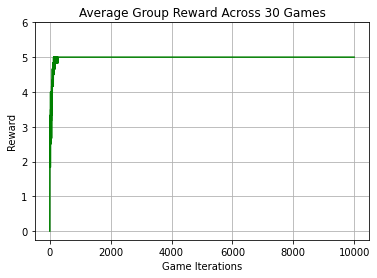

In [6]:
# The plot
plt.plot(avg_df, color = "green")
plt.title('Average Group Reward Across 30 Games')
plt.xlabel('Game Iterations')
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Reward')
plt.grid()
plt.show()

# Scenario 2 (Fixed Sender With Value Based Role Selection)
Class Agent

In [5]:
import numpy as np
import pandas as pd
import torch, math, random

class Agent():
    def __init__(self):
        # Agent roles -> 0:A, 1:B, 2:C
        self.role = None
        self.p_adding_signals = 0.1
        self.payoff = None
        self.P_A = 0.5
        self.P_B = 0.5
        self.V_A = 10
        self.V_B = 10
        self.signals = []
        self.sender = False
        self.receiver = False
        self.lr = 0.5
        self.chosen_sig = None
        self.p_exploration = 0.1
        self.confidence_threshhold = 0.1
        self.decay_signals = 0.99

    def pick_best_word(self, word_list):
        best_word = [word for word in word_list if word[-1] == max([sublist[-1] for sublist in word_list])]
        return best_word[0]

    def create_signal(self, rand_nr, counter, chosen_signal):
        if rand_nr < self.p_adding_signals:
            sig1 = "w" + str(counter)
            counter += 1
            generated_signal = [sig1, self.role, 0.5]
            self.signals.append(generated_signal)
            chosen_signal = generated_signal
        return chosen_signal, counter

    def check_signals(self, chosen_signal):
        words_known = []
        for word in self.signals:
            if word[1] == self.role:
                words_known.append(word)
        if len(words_known) != 0:
            chosen_signal = self.pick_best_word(words_known)
        return chosen_signal
    
    def send_signal(self,counter):
        chosen_signal = None
        rand_nr = random.uniform(0,1)
        if self.sender:
            if len(self.signals) != 0:
                chosen_signal = self.check_signals(chosen_signal)
                if chosen_signal is not None:
                    return chosen_signal, counter

                rand_signal = self.create_signal(rand_nr, counter, chosen_signal)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal, counter
            else:
                rand_signal = self.create_signal(rand_nr, counter, chosen_signal)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal, counter
        return chosen_signal, counter

    def select_role(self):
        rand_nr = random.uniform(0,1)
        if self.receiver:
            if self.P_A > self.P_B:
                self.role = 0
            elif self.P_B > self.P_A:
                self.role = 1
            else:
                self.role = random.choice([0,1])
        elif self.sender:
            if rand_nr < self.p_exploration:
                if self.V_A > self.V_B:
                    self.role = 1
                elif self.V_B > self.V_A:
                    self.role = 0
                else:
                    self.role = random.choice([0,1])
            else:
                if self.V_A > self.V_B:
                    self.role = 0
                elif self.V_B > self.V_A:
                    self.role = 1
                else:
                    self.role = random.choice([0,1])
        else:
            self.role = random.choice([0,1])
        return self.role

    def decay_confidences(self):
        for elm1 in self.signals:
            elm1[-1] = elm1[-1] * self.decay_signals
    
    def remove_unused_signals(self):
        for elm1 in self.signals:
            if elm1[-1] < self.confidence_threshhold:
                self.signals.remove(elm1)
    
    def update_probabilities(self, chosen_signal):
        if self.receiver:
            if chosen_signal is not None:
                if len(self.signals) != 0:
                    for sigs in self.signals:
                        if chosen_signal[0] == sigs[0]:
                            self.chosen_sig = sigs
                            if sigs[1] == 0:
                                self.P_A = 1
                                self.P_B = 0
                                return True
                            elif sigs[1] == 1:
                                self.P_A = 0
                                self.P_B = 1
                                return True

                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    self.signals.append([chosen_signal[0], rand_ind, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, 0.5]
                    return True
                else:
                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    self.signals.append([chosen_signal[0], rand_ind, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, 0.5]
                    return True
        return True
    
    def update_values(self, reward):
        # Updating values of roles
        if self.role == 0:
            self.V_A += self.lr * (reward-self.V_A)
        elif self.role == 1:
            self.V_B += self.lr * (reward-self.V_B)

The Game

In [6]:
results = []
agreements = []
payoffsTrendRounds = []
nr_experiments = 30
for gameRound in range(nr_experiments):
    # Settings:
    nr_agents = 2
    time = 10000
    c_time = 1
    agents = []
    learning_rate = 0.5
    counter = 0
    pairs1 = np.zeros(time)
    pairs2 = np.zeros(time)

    # Create agents:
    for i in range(nr_agents):
        agents.append(Agent())
        agents[i].payoff = np.zeros(time)

    # Determine Pairs of Sender and Recievers only once throughout the game
    rand_index_sender = random.choice(range(len(agents)))
    sender_agent = agents[rand_index_sender]
    receiver_agent = agents[1-rand_index_sender]
    sender_agent.sender = True
    sender_agent.receiver = False
    receiver_agent.sender = False
    receiver_agent.receiver = True
    
    # The main framework that controls the game
    for t in range(1, time):
        selections_list = []
        # communication phase
        sender_agent.select_role()
        selections_list.append(sender_agent.role)
        sent = sender_agent.send_signal(counter)
        chosen_signal = sent[0]
        counter = sent[1]
        receiver_agent.update_probabilities(chosen_signal)
        receiver_agent.select_role()
        selections_list.append(receiver_agent.role) 
        payoffs_list = np.zeros(len(agents))
    
        # Check signals after each 10 iteration
        if t%2 == 0:
            for agent in agents:
                agent.remove_unused_signals()
    
        # Calculate payoffs
        # To change the Games, simply uncomment the corresponding lines and comment the othe rules
    #################################################################################################
        # Games 1: All agents must have the same roles
        for i in range(len(agents)):
            if all(roles == selections_list[0] for roles in selections_list):
                payoffs_list[i] += 5
            else:            
                payoffs_list[i] += 0
    #################################################################################################
        # # Games 2: All agents must not have the same roles
        # for i in range(len(agents)):
        #     if not all(roles == selections_list[0] for roles in selections_list):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # # Games 3: Sender must have role A (0), Receivers must have role B (1)
        # for i in range(len(agents)):
        #     if (sender_agent.role == 0) and (receiver_agent.role == 1):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################

        # distribute rewards
        for i in range(len(agents)):
            agents[i].payoff[t] = payoffs_list[i]
            agents[i].update_values(agents[i].payoff[t])
            agents[i].decay_confidences()
        # Check if communication was successful
        if chosen_signal is not None:
            for elm1 in sender_agent.signals:
                if elm1 == chosen_signal:
                    elm1[-1] += learning_rate * (sender_agent.payoff[t] - elm1[-1])
                    if elm1[-1] < 0:
                        elm1[-1] = 0
                    elif elm1[-1] > 1:
                        elm1[-1] = 1
            for elm2 in receiver_agent.signals:
                if elm2 == receiver_agent.chosen_sig:
                    elm2[-1] += learning_rate * (receiver_agent.payoff[t] - elm2[-1])
                    if elm2[-1] < 0:
                        elm2[-1] = 0
                    elif elm2[-1] > 1:
                        elm2[-1] = 1

    # Checking the semantic similarity between all agents
    # Note: to match the corresponding Games, uncomment the corresponding section and comment the others
    #################################################################################################
    # Matching with Games 1:
    successful = []
    signal_list = [receiver_agent.signals, sender_agent.signals]
    for x,y in zip(*signal_list):
        if (x[-1] > 0.5) and (y[-1] > 0.5):
            successful.append((x[0]==y[0]) and (x[1]==y[1]))
    #################################################################################################
    # # Matching with Games 2, 3:
    # successful = []
    # signal_list = [receiver_agent.signals, sender_agent.signals]
    # for x,y in zip(*signal_list):
    #     if (x[-1] > 0.5) and (y[-1] > 0.5):
    #         successful.append((x[0]==y[0]) and not(x[1]==y[1]))
    #################################################################################################

    f5 = open("Scenario2_results.txt", "a")
    print("\n\nRound {}".format(gameRound), sep=',', file=f5)
    print("Game {}".format(t), sep=',', file=f5)
    for i in range(len(agents)):
        print("agent[{}] signals is:{}".format(i, agents[i].signals), sep=',', file=f5)
    f5.close()

    result = []
    for i in range(len(agents)):
        result.append(agents[i].payoff)
    results.append(result)
    if all(x == True for x in successful):
        agreed = True
    else:
        agreed = False
    agreements.append(agreed)

In [7]:
results_df = pd.DataFrame(results)
sum_df = 0
for i in range(len(results_df.columns)):
    sum_df += results_df[i]
avg_df = (sum_df / len(results_df.columns)).mean()
agreement_percent = (agreements.count(True) / len(agreements) ) * 100
print("the percentage of the games that had agreement is:{}%".format(agreement_percent))

the percentage of the games that had agreement is:100.0%


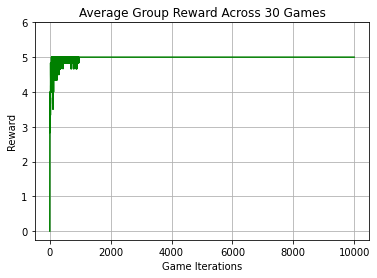

In [8]:
# The plot
plt.plot(avg_df, color = "green")
plt.title('Average Group Reward Across 30 Games')
plt.xlabel('Game Iterations')
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Reward')
plt.grid()
plt.show()